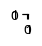

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


In [47]:
gliph = pd.read_csv('../output/GLIPH/GLIPH_KCV_POS_ONLY.csv')
gliph['pep'] = gliph['Sample'].apply(lambda x:x[8:])
print(gliph.columns)
display(gliph[['ulTcRb', 'TcRa', 'TcRb', 'Sample', 'pep', 'index', 'pattern']])

Index(['index', 'pattern', 'Fisher_score', 'number_subject',
       ' number_unique_cdr3', ' final_score', 'hla_score', 'vb_score',
       'expansion_score', 'length_score', 'cluster_size_score', 'type',
       'ulTcRb', 'TcRb', 'V', 'J', 'TcRa', 'Sample', 'Freq', 'HLA-A', 'HLA-B',
       'HLA-C', 'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1',
       'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5', 'pep'],
      dtype='object')


,ulTcRb,TcRa,TcRb,Sample,pep,index,pattern
0,CASSIrsTGELF,CAVTYGGSQGNLIF,CASSIRSTGELF,51/8030:GILGFVFTL,GILGFVFTL,1,SIRS
1,CASSIrsNTEAFF,CAGDSGGGSQGNLIF,CASSIRSNTEAFF,99/1201:GILGFVFTL,GILGFVFTL,1,SIRS
2,CASSIrSGvEQYF,CAGGGDGGSQGNLIF,CASSIRSGVEQYF,83/6796:GILGFVFTL,GILGFVFTL,1,SIRS
3,CASSIrSGvEQYF,CAESIGRGSQGNLIF,CASSIRSGVEQYF,65/8923:GILGFVFTL,GILGFVFTL,1,SIRS
4,CASSIrsddIQYF,CGTADGGSQGNLIF,CASSIRSDDIQYF,59/6999:GILGFVFTL,GILGFVFTL,1,SIRS
...,...,...,...,...,...,...,...
4177,CASSSrdGGTDTQYF,CAGGGSQGNLIF,CASSSRDGGTDTQYF,12/7884:GILGFVFTL,GILGFVFTL,4780,single
4178,CASSSrdGGTDTQYF,CAAPYGGSQGNLIF,CASSSRDGGTDTQYF,87/9853:GILGFVFTL,GILGFVFTL,4780,single
4179,CASSSrdGGTDTQYF,CAGAGSGYALNF,CASSSRDGGTDTQYF,47/4997:RAKFKQLL,RAKFKQLL,4780,single
4180,CASSSrdGGTDTQYF,CAVRDHSGNTPLVF,CASSSRDGGTDTQYF,10/2585:RAKFKQLL,RAKFKQLL,4780,single


,TcRa,TcRb,index,pattern
0,CAVTYGGSQGNLIF,CASSIRSTGELF,1,SIRS
1,CAGDSGGGSQGNLIF,CASSIRSNTEAFF,1,SIRS
2,CAGGGDGGSQGNLIF,CASSIRSGVEQYF,1,SIRS
3,CAESIGRGSQGNLIF,CASSIRSGVEQYF,1,SIRS
4,CGTADGGSQGNLIF,CASSIRSDDIQYF,1,SIRS
...,...,...,...,...
4177,CAGGGSQGNLIF,CASSSRDGGTDTQYF,4780,single
4178,CAAPYGGSQGNLIF,CASSSRDGGTDTQYF,4780,single
4179,CAGAGSGYALNF,CASSSRDGGTDTQYF,4780,single
4180,CAVRDHSGNTPLVF,CASSSRDGGTDTQYF,4780,single


# Create new dataset, with merging in ImmRep negatives

--> Need to create new dataset class and/or adapt in order to do "burn_in" with negatives

- [ ] Run two new sets of experiments, train to perfect accuracy with 40k epochs, taking a subset of top 15 binders, no 10X —> only 20 peps left
    - [ ] With Cos weight = 1
    - [ ] With Cos weight = 5
    - [ ] With Cos weight = 10
    - [ ] With and Without adding negatives from ImmRep as burn-in (10k epochs burn-in) ; If burn-in, then do same total amount of epochs (40k total)

In [22]:
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
new_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
new_refilt_no10x = pd.read_csv('../data/filtered/240410_NetTCR_expanded_min20binders_NO_10x.csv')
new_refilt_w10x = pd.read_csv('../data/filtered/240410_NetTCR_expanded_min20binders_with_10x.csv')
negs = pd.read_csv('../data/multimodal/240311_immrepnegs_tcrs.csv').rename(columns={'db':'origin'}).assign(binder=0)

In [33]:
from sklearn.model_selection import KFold
num_splits = 5
# Initialize KFold with the desired number of splits
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
# Assign partitions using KFold
partition = 0
for _, train_index in kf.split(negs):
    negs.loc[train_index, 'partition'] = partition
    partition += 1
# Convert partition column to integers
negs['partition'] = negs['partition'].astype(int)
# Display the DataFrame with the new 'partition' column
negs.head()

,A1,A2,A3,B1,B2,B3,origin,peptide,binder,partition
0,DSAIYN,IQSSQRE,AALTTDSWGKLQ,SQVTM,ANQGSEA,SVRNTEAF,immrep_negs,XXXXXXXXX,0,1
1,SSVPPY,YTSAATLV,AVSERAGGTSYGKLT,SGHDT,YYEEEE,ASSSGQGAPYEQY,immrep_negs,XXXXXXXXX,0,4
2,TTLSN,LVKSGEV,AGPEENSGYSTLT,SGHKS,YYEKEE,ASSLVGNEQF,immrep_negs,XXXXXXXXX,0,3
3,SIFNT,LYKAGEL,AGENAGGTSYGKLT,SGHTA,FQGTGA,ASSLQVGDYNEQF,immrep_negs,XXXXXXXXX,0,0
4,NSASQS,VYSSG,VVSYNTDKLI,SNHLY,FYNNEI,ASSDLFSGQGGNIQY,immrep_negs,XXXXXXXXX,0,4


In [48]:
pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv').groupby('origin').count()

,A1,A2,A3,B1,B2,B3,peptide,allele,binder,partition,original_peptide,original_index
origin,,,,,,,,,,,,
10x,4049,4049,4049,4049,4049,4049,4049,4049,4049,4049,4049,4049
IEDB,182,182,182,182,182,182,182,182,182,182,182,182
VDJdb,1673,1673,1673,1673,1673,1673,1673,1673,1673,1673,1673,1673


In [35]:
old_merged = pd.concat([old_df, negs]).sort_values('partition').reset_index(drop=True)
old_no10x_merged = pd.concat([old_df.query('origin!="10x"'), negs]).sort_values('partition').reset_index(drop=True)
new_merged = pd.concat([new_df, negs]).sort_values('partition').reset_index(drop=True)
new_ref_no10x = pd.concat([new_refilt_no10x, negs]).sort_values('partition').reset_index(drop=True)
new_ref_w10x = pd.concat([new_refilt_w10x, negs]).sort_values('partition').reset_index(drop=True)
old_merged['burn_in'] = old_merged['origin']=="immrep_negs"
old_no10x_merged['burn_in'] = old_no10x_merged['origin']=="immrep_negs"
new_merged['burn_in'] = new_merged['origin']=="immrep_negs"
new_ref_no10x['burn_in'] = new_ref_no10x['origin']=="immrep_negs"
new_ref_w10x['burn_in'] = new_ref_w10x['origin']=="immrep_negs"

In [59]:
model_folder = '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/'
files = glob.glob(f'{model_folder}*.pt')
names = ['_'.join(os.path.basename(x.replace(model_folder, '')).split('_')[:2]) for x in files]
js = glob.glob(f'{model_folder}*JSON*.json')[0]
files[:3], names, js


(['../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/epoch_6000_interval_checkpoint__fold00_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62.pt',
  '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/epoch_24000_interval_checkpoint__fold00_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62.pt',
  '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/epoch_30000_interval_checkpoint__fold00_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62.pt'],
 ['epoch_6000',
  'epoch_24000',
  'epoch_30000',
  'epoch_3000',
  'epoch_9000',
  'epoch_21000',
  'epoch_27000',
  'epoch_18000',
  'epoch_12000',
  'e

In [61]:
import re

def sort_key(item):
    if item == 'last_epoch':
        return float('inf'), 1  # last_epoch will be the second last
    elif item == 'checkpoint_best':
        return float('inf'), 2  # checkpoint_best will be last
    else:
        # Extract the number from strings like 'epoch_6000' and convert to integer
        return int(re.search(r'\d+', item).group()), 0
        
# Sort the list with the custom key
sorted_epochs = sorted(epochs, key=sort_key)

print(sorted_epochs)


['epoch_3000', 'epoch_6000', 'epoch_9000', 'epoch_12000', 'epoch_15000', 'epoch_18000', 'epoch_21000', 'epoch_24000', 'epoch_27000', 'epoch_30000', 'last_epoch', 'checkpoint_best']


In [71]:
# Assuming we are using VAE based models 
files = glob.glob(f'{model_folder}*.pt')
epochs = ['_'.join(os.path.basename(x.replace(model_folder, '')).split('_')[:2]) for x in files]

sorted_epochs = sorted(epochs, key=sort_key)
map_epochs_files = {k:v for k,v in zip(epochs, files)}


{'epoch_6000': '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/epoch_6000_interval_checkpoint__fold00_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62.pt',
 'epoch_24000': '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/epoch_24000_interval_checkpoint__fold00_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62.pt',
 'epoch_30000': '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62/epoch_30000_interval_checkpoint__fold00_kcv_240311_nettcr_pairedAB_expanded_noswap_f00_240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_LC62.pt',
 'epoch_3000': '../output/240415_BL62LO_models/240415_1209_BL62LO_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KF

In [72]:
import glob
from src.torch_utils import load_model_full

def run_interval_clustering(model_folder, input_df, identifier='VAEmodel'):
    # Assuming we are using VAE based models 
    files = glob.glob(f'{model_folder}*.pt')
    epochs = ['_'.join(os.path.basename(x.replace(model_folder, '')).split('_')[:2]) for x in files]

        
    sorted_epochs = sorted(epochs, key=sort_key)
    map_epochs_files = {k:v for k,v in zip(epochs, files)}

    js = glob.glob(f'{model_folder}*JSON*.json')[0]
    cat_results = []
    for name in sorted_epochs:
        checkpoint = map_epochs_files[name]
        model = load_model_full(checkpoint, js, map_location='cpu')
        latent_df = get_latent_df(model, input_df)
        dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels(latent_df)
        results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder)
        results['model'] = identifier
        results['epoch'] = name
        cat_results.append(results)
    return pd.concat(cat_results)